# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import os

In [3]:
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from datetime import datetime as dt
import pytz

In [4]:
PATH = 'data/nyc-taxi/'
CSV_PATH = 'submissions/v11_ensemble_16trees_54M_rows/'

# Helper functions

In [5]:
def split_df(df, y_fld, subset=None, random_state=42):
    
    if subset: df = df.sample(n=subset, random_state=random_state)

    y = df[y_fld].values
    df.drop(y_fld, axis=1, inplace=True)
    
    return df, y

# Load data

In [6]:
seed = 24 # random seed for replication

In [7]:
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt5')
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt5')
test_df_raw = pd.read_csv(f'{PATH}test.csv', usecols=['key'])

In [8]:
train_df.shape, test_df.shape

((54053965, 24), (9914, 23))

In [9]:
%%time
subsample = 1_000_000

X_train, y_train = split_df(train_df, 'fare_amount', subset=subsample, random_state=seed)

# X_train, y_train = split_df(train_df, 'fare_amount')

Wall time: 5.14 s


In [10]:
X_train.shape, y_train.shape, test_df.shape

((1000000, 23), (1000000,), (9914, 23))

# Batch fit

In [ ]:
outdir = CSV_PATH
os.makedirs(outdir, exist_ok=True)
preds = []
n_forest=20
tz = pytz.timezone('Asia/Singapore')

In [ ]:
%%time
for i in range (n_forest):
    
    new_seed = i + 12346
    
    print(f"Random Forest [{i+1}/{n_forest}] of 16 trees with random seed {new_seed}")
    m = RandomForestRegressor(n_estimators=16, min_samples_leaf=3, max_features=0.4, n_jobs=-1, random_state=new_seed)
    
    print("Fitting on training data...")
    m.fit(X_train, y_train)

    print("Predicting on test data...")
    test_y_predictions = m.predict(test_df)
    preds.append(test_y_predictions)      
    
    print("Creating submission file...")
    
    cur_dt = dt.now(tz).strftime("%Y%m%d_%H%M%S")
    desc = 'v11_RF_' # description of submission for reference
    ensemb_desc = '_01x16_54M'
    subm_fn =  desc + cur_dt + ensemb_desc + '.csv'
    subm_path = f'{outdir}/{subm_fn}'

    # Write the predictions to a CSV file which we can submit to the competition.
    submission = pd.DataFrame(
        {'key': test_df_raw.key, 'fare_amount': test_y_predictions},
        columns = ['key', 'fare_amount'])
    submission.to_csv(subm_path, index = False)
    
    print(f"Submission: {subm_fn}")
    print()

In [ ]:
# test_y_predictions = np.mean(np.vstack([preds]),axis=0)

# Results

# Save model

In [18]:
import pickle
from fastai.imports import *
from fastai.structured import *

In [ ]:
m=models[0]

In [ ]:
model_fn_save = 'tmp/rf_model.pkl'

In [ ]:
%time pickle.dump(m, open(model_fn_save, 'wb'))

# Load Model

In [14]:
model_fn_open = 'tmp/rf_model.pkl'

In [15]:
%time rf = pickle.load(open(model_fn_open, 'rb'))

Wall time: 1min 28s


In [20]:
fi = rf_feat_importance(rf, X_train)

,cols,imp
7,simple_distance,0.486936
5,longitude_distance,0.121831
14,pickup_distance_to_nyc,0.106635
6,latitude_distance,0.039490
17,dropoff_distance_to_jfk,0.034967
15,dropoff_distance_to_nyc,0.031534
21,dropoff_distance_to_lgr,0.027300
2,dropoff_longitude,0.024846
22,fare_increased,0.016478
3,dropoff_latitude,0.015845


In [23]:
fi

,cols,imp
7,simple_distance,0.486936
5,longitude_distance,0.121831
14,pickup_distance_to_nyc,0.106635
6,latitude_distance,0.039490
17,dropoff_distance_to_jfk,0.034967
15,dropoff_distance_to_nyc,0.031534
21,dropoff_distance_to_lgr,0.027300
2,dropoff_longitude,0.024846
22,fare_increased,0.016478
3,dropoff_latitude,0.015845


In [21]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

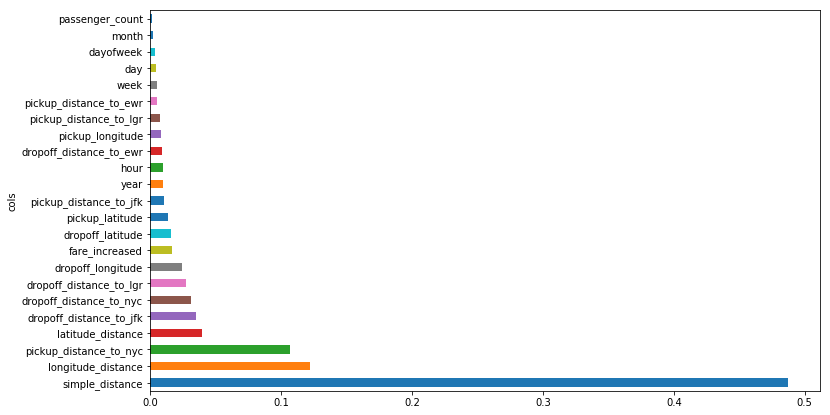

In [22]:
plot_fi(fi);

In [24]:
from scipy.cluster import hierarchy as hc

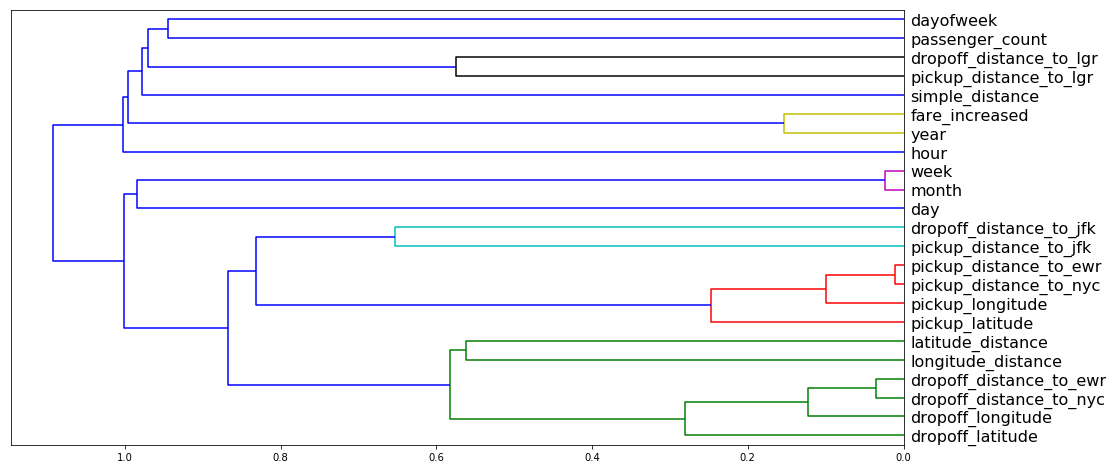

In [27]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,8))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()